In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
import xgboost as xgb 
import sklearn.multioutput

%matplotlib inline 

In [2]:
# Throw away lepton mass 

be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['bh_eta', 'bh_m', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_m', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_DL1r', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue', 'th_eta', 'th_m', 'th_phi', 'th_pt', 'tl_eta', 'tl_m', 'tl_phi', 'tl_pt', 'true_lep_eta', 'true_lep_m', 'true_lep_phi', 'true_lep_pt', 'wh_eta', 'wh_m', 'wh_phi', 'wh_pt', 'wl_eta', 'wl_m', 'wl_phi', 'wl_pt']>


In [3]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

In [4]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [5]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if key == 'tl_phi' or key == 'wl_phi':
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi2_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if full_key == 'tl_phi' or full_key == 'wl_phi':
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi2_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [6]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)

In [7]:
# Test inverse scaling

if False:
    plt.figure(figsize=(8,8*output_length))
    for i in range(len(output_keys)):
        plt.subplot(output_length, 1, i+1)
        plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
        plt.xlabel(output_keys[i] + " scaling error")
        plt.ylabel('Frequency')

In [8]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

trainX, testX = total_input[0:split, :], total_input[split:,:]
trainY, testY = total_output[0:split,:], total_output[split:,:]

In [9]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(80000, 36) (80000, 9)
(20000, 36) (20000, 9)


In [10]:
# Histograms of output variables 
show = False

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

In [11]:
# Histograms of input variables 
show = False

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [12]:
Dtrain = xgb.DMatrix(trainX, label=trainY)
Dtest = xgb.DMatrix(testX, label=testY)

model = sklearn.multioutput.MultiOutputRegressor(xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth = 10, alpha = 1, n_estimators = 256, verbosity=2))

In [13]:
model.fit(trainX,trainY)

/home/hongtao/miniconda3/envs/top-ml/lib/python3.8/site-packages/xgboost/core.py:442: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 888 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 840 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 942 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1014 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 984 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 870 extra nodes, 0 pruned nodes, max_depth=10
[14:51:24] INFO: /works

[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1088 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1000 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 680 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 570 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 836 extra nodes, 0 pruned nodes, max_depth=10
[14:51:27] INFO: /work

[14:51:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 564 extra nodes, 0 pruned nodes, max_depth=10
[14:51:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[14:51:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[14:51:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[14:51:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[14:51:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 614 extra nodes, 0 pruned nodes, max_depth=10
[14:51:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=10
[14:51:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 956 extra nodes, 0 pruned nodes, max_depth=10
[14:51:31] INFO: /worksp

[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 600 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 588 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 676 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 832 extra nodes, 0 pruned nodes, max_depth=10
[14:51:34] INFO: /worksp

[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1128 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1282 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1186 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1174 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1278 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1222 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1258 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1146 extra nodes, 0 pruned nodes, max_depth=10
[14:51:37] INFO:

[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 726 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[14:51:40] INFO: /worksp

[14:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[14:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[14:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[14:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1096 extra nodes, 0 pruned nodes, max_depth=10
[14:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1128 extra nodes, 0 pruned nodes, max_depth=10
[14:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 502 extra nodes, 0 pruned nodes, max_depth=10
[14:51:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[14:51:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[14:51:44] INFO: /work

[14:51:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1006 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 810 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 582 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 774 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 854 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 740 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 904 extra nodes, 0 pruned nodes, max_depth=10
[14:51:47] INFO: /works

[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 830 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 998 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 992 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1204 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 700 extra nodes, 0 pruned nodes, max_depth=10
[14:51:50] INFO: /works

[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1154 extra nodes, 0 pruned nodes, max_depth=10
[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 878 extra nodes, 0 pruned nodes, max_depth=10
[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 742 extra nodes, 0 pruned nodes, max_depth=10
[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1144 extra nodes, 0 pruned nodes, max_depth=10
[14:51:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 568 extra nodes, 0 pruned nodes, max_depth=10
[14:51:54] INFO: /work

[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 918 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 806 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 832 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 766 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1020 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=10
[14:51:57] INFO: /work

[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 704 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 528 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 834 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 520 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 898 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 868 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[14:52:00] INFO: /worksp

[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 904 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 570 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 728 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 722 extra nodes, 0 pruned nodes, max_depth=10
[14:52:03] INFO: /worksp

[14:52:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[14:52:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[14:52:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 568 extra nodes, 0 pruned nodes, max_depth=10
[14:52:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[14:52:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[14:52:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=10
[14:52:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[14:52:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[14:52:07] INFO: /worksp

[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 674 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 682 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 848 extra nodes, 0 pruned nodes, max_depth=10
[14:52:10] INFO: /worksp

[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1010 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1056 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1046 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1080 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1030 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1088 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1074 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1026 extra nodes, 0 pruned nodes, max_depth=10
[14:52:13] INFO:

[14:52:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[14:52:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=10
[14:52:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 844 extra nodes, 0 pruned nodes, max_depth=10
[14:52:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=10
[14:52:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[14:52:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 700 extra nodes, 0 pruned nodes, max_depth=10
[14:52:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 596 extra nodes, 0 pruned nodes, max_depth=10
[14:52:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[14:52:17] INFO: /worksp

[14:52:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[14:52:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=10
[14:52:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1026 extra nodes, 0 pruned nodes, max_depth=10
[14:52:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1234 extra nodes, 0 pruned nodes, max_depth=10
[14:52:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 746 extra nodes, 0 pruned nodes, max_depth=10
[14:52:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[14:52:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[14:52:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=10
[14:52:20] INFO: /work

[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 580 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 588 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 692 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 898 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 746 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1092 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[14:52:23] INFO: /works

[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 898 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1388 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 578 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 742 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 830 extra nodes, 0 pruned nodes, max_depth=10
[14:52:26] INFO: /works

[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 728 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1140 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 532 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1084 extra nodes, 0 pruned nodes, max_depth=10
[14:52:29] INFO: /work

[14:52:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[14:52:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 928 extra nodes, 0 pruned nodes, max_depth=10
[14:52:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 934 extra nodes, 0 pruned nodes, max_depth=10
[14:52:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[14:52:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 938 extra nodes, 0 pruned nodes, max_depth=10
[14:52:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 926 extra nodes, 0 pruned nodes, max_depth=10
[14:52:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 866 extra nodes, 0 pruned nodes, max_depth=10
[14:52:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=10
[14:52:33] INFO: /worksp

[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 840 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1104 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 776 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[14:52:36] INFO: /works

[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 968 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 796 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 590 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 794 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[14:52:39] INFO: /worksp

[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 672 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 924 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=10
[14:52:42] INFO: /worksp

[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 770 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1114 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 772 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 746 extra nodes, 0 pruned nodes, max_depth=10
[14:52:45] INFO: /works

[14:52:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=10
[14:52:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 736 extra nodes, 0 pruned nodes, max_depth=10
[14:52:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 844 extra nodes, 0 pruned nodes, max_depth=10
[14:52:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 874 extra nodes, 0 pruned nodes, max_depth=10
[14:52:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1018 extra nodes, 0 pruned nodes, max_depth=10
[14:52:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 994 extra nodes, 0 pruned nodes, max_depth=10
[14:52:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1058 extra nodes, 0 pruned nodes, max_depth=10
[14:52:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 996 extra nodes, 0 pruned nodes, max_depth=10
[14:52:49] INFO: /work

[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 726 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 622 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1246 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1118 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1000 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 680 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 700 extra nodes, 0 pruned nodes, max_depth=10
[14:52:52] INFO: /wor

[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 936 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 1052 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 568 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 884 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[14:52:55] INFO: /works

[14:52:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 660 extra nodes, 0 pruned nodes, max_depth=10
[14:52:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=10
[14:52:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=10
[14:52:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 878 extra nodes, 0 pruned nodes, max_depth=10
[14:52:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 590 extra nodes, 0 pruned nodes, max_depth=10
[14:52:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=10
[14:52:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[14:52:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 966 extra nodes, 0 pruned nodes, max_depth=10
[14:52:59] INFO: /worksp

[14:53:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[14:53:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 582 extra nodes, 0 pruned nodes, max_depth=10
[14:53:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 720 extra nodes, 0 pruned nodes, max_depth=10
[14:53:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=10
[14:53:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[14:53:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=10
[14:53:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 732 extra nodes, 0 pruned nodes, max_depth=10
[14:53:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[14:53:02] INFO: /worksp

[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=10
[14:53:05] INFO: /worksp

[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 680 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 622 extra nodes, 0 pruned nodes, max_depth=10
[14:53:08] INFO: /worksp

[14:53:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[14:53:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[14:53:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[14:53:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[14:53:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 660 extra nodes, 0 pruned nodes, max_depth=10


MultiOutputRegressor(estimator=XGBRegressor(alpha=1, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=256, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:squarederro

In [14]:
predictions = model.predict(testX)

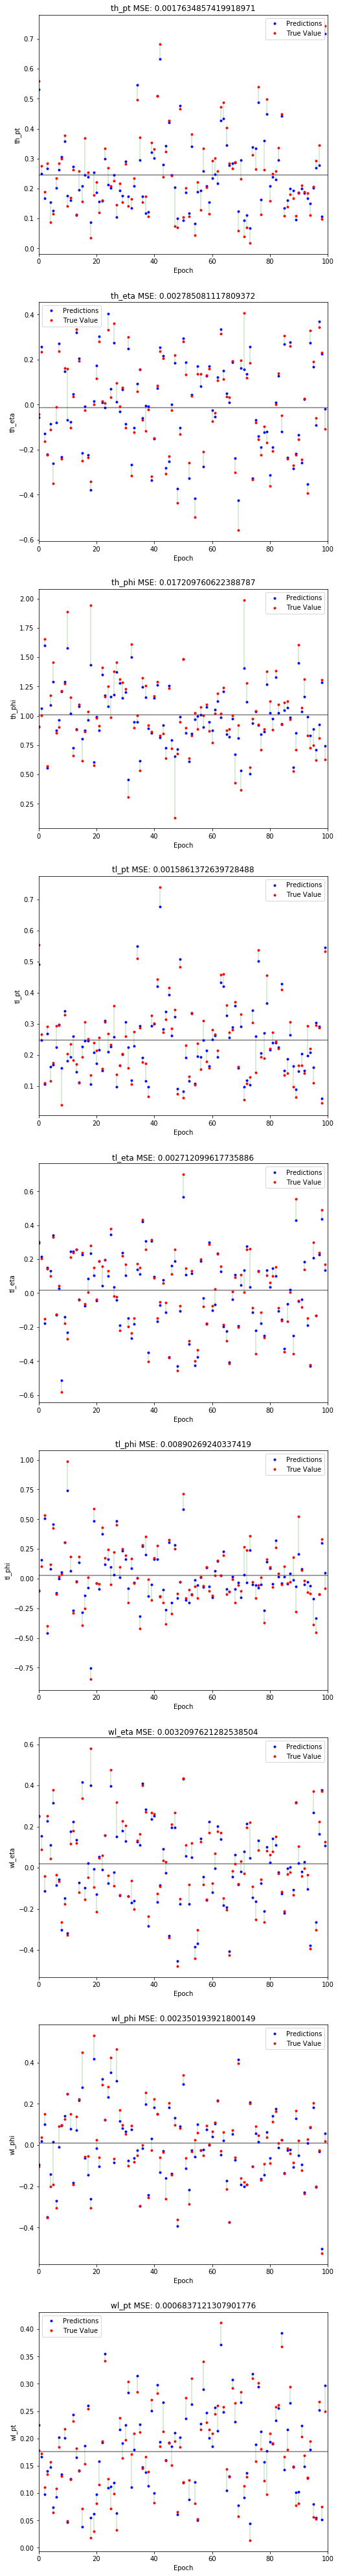

In [15]:

# Training 
crop = 100 

train_small = model.predict(trainX[0:100,:])
output_small = trainY[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [16]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.028642107960739835
th_pt MSE :  0.0056444044
th_eta MSE :  0.0159257427
th_phi MSE :  0.1120854572
tl_pt MSE :  0.0045047034
tl_eta MSE :  0.0125079635
tl_phi MSE :  0.0728688513
wl_eta MSE :  0.0086379895
wl_phi MSE :  0.0236608824
wl_pt MSE :  0.0019429771


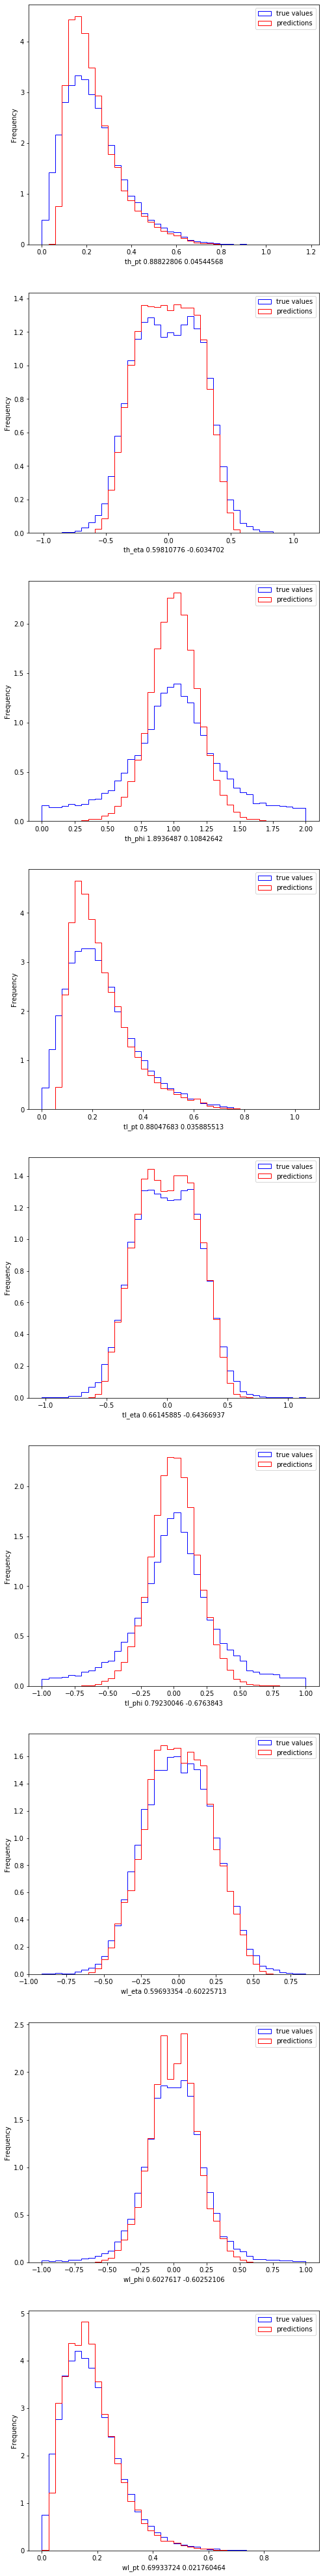

In [17]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

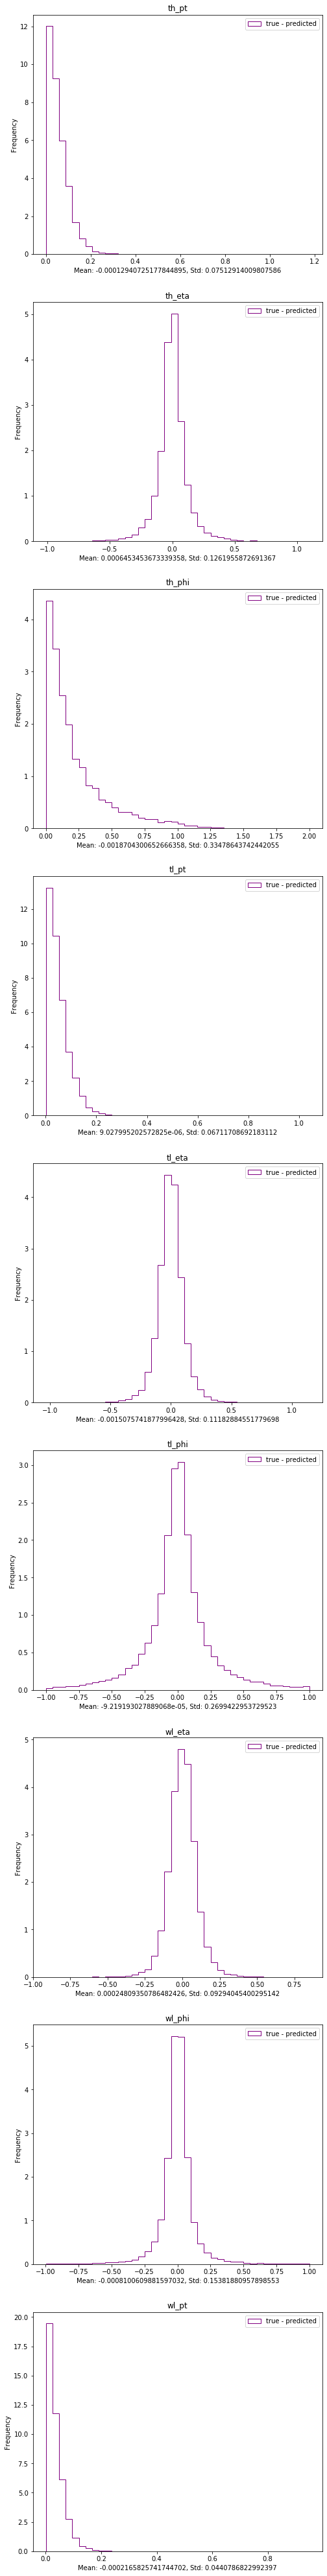

In [18]:
# True - Predicted 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [19]:
total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]


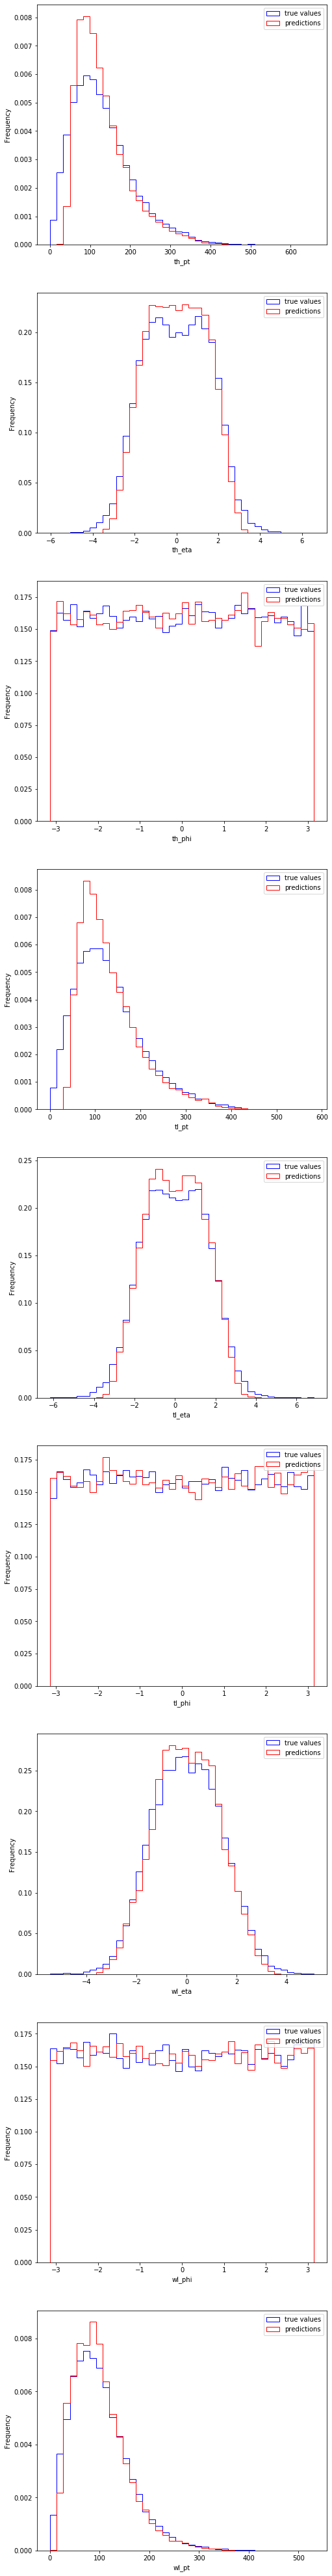

In [20]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, testY, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

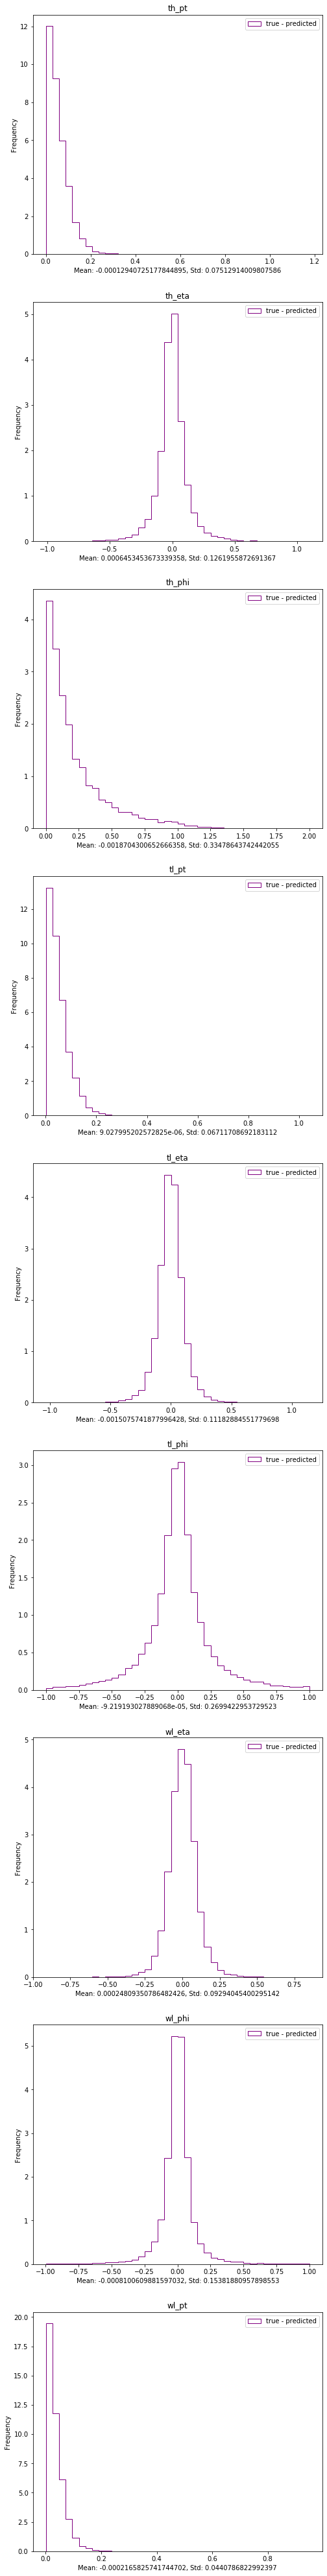

In [21]:
# True - Predicted 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

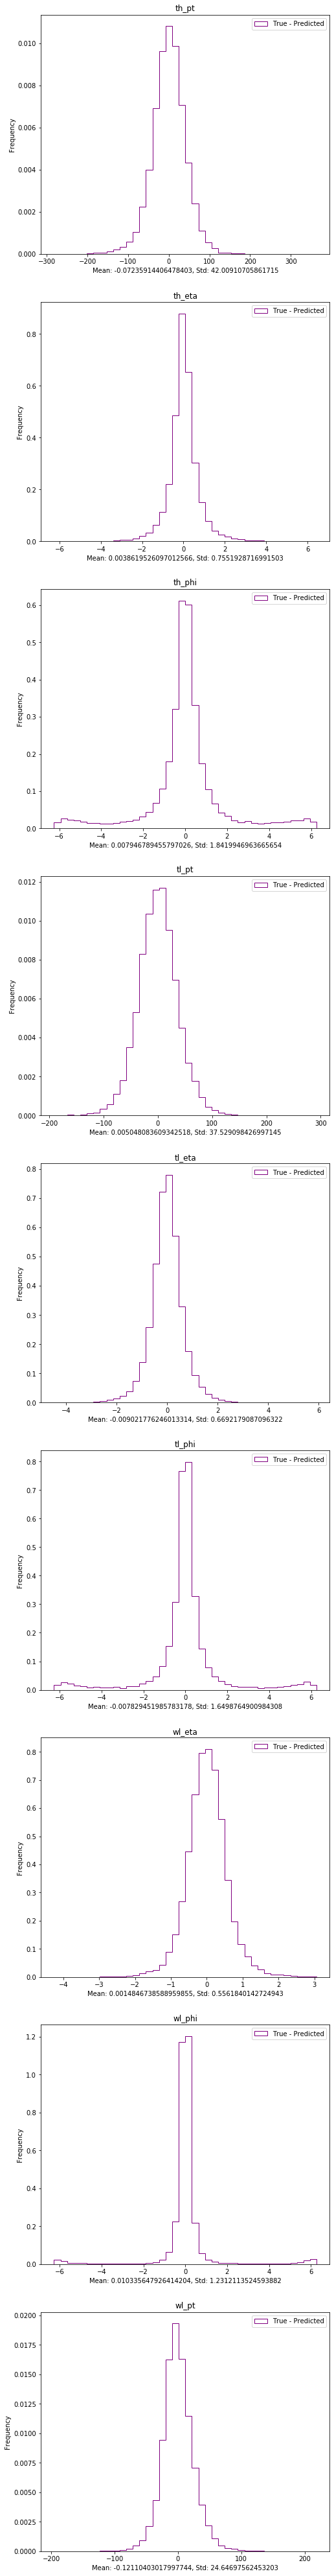

In [22]:
# Difference value histograms 
plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [23]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1764.7703117081
Original Scale th_eta MSE :  0.5703311881
Original Scale th_phi MSE :  1.0256565160
Original Scale tl_pt MSE :  1408.4332542264
Original Scale tl_eta MSE :  0.4479340018
Original Scale tl_phi MSE :  0.6722992496
Original Scale wl_eta MSE :  0.3093428620
Original Scale wl_phi MSE :  0.2119014052
Original Scale wl_pt MSE :  607.4880736224


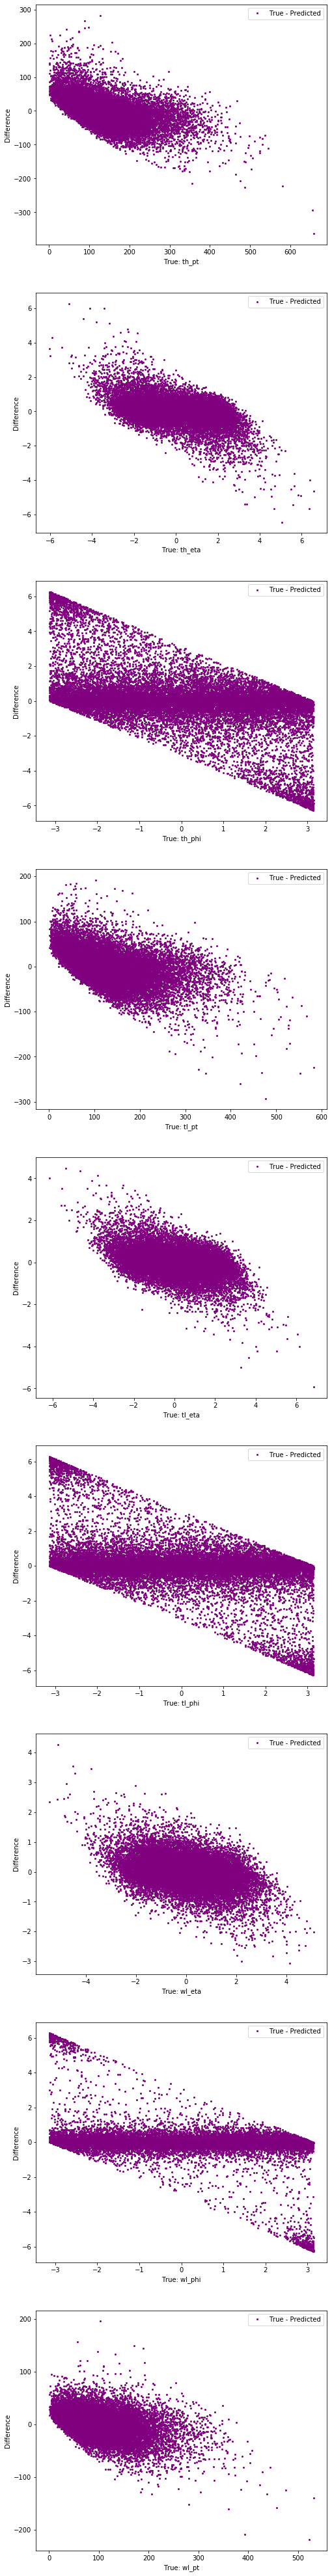

In [24]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')